### Machine Learning

This notebook trains serveral models to predict potato yields. It also utilises some dimensionality reduction and clustering.

It also does a sentiment analysis on Twitter Data and performs classification machine learning.

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [3]:
# Read in the data and drop un-necessary columns
# Note I need two dataframes, one drops the metadata around crops, geo etc, the other does not
# I need the full dataset for adding a lag later

df_merged_hot_full = pd.read_csv('df_merged_hot.csv')

df_merged_hot_full.drop(columns = 'Unnamed: 0', inplace = True)

df_merged_hot = df_merged_hot_full.drop(columns = ['crops', 'strucpro', 'geo', 'Year'])

In [4]:
# Producing train and test splits

y = df_merged_hot['Yields']
X = df_merged_hot.drop(columns = 'Yields')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((270, 77), (68, 77), (270,), (68,))

In [5]:
# I'll begin by running a linear regression

In [6]:
# Instantiate Linear Regression and fit model on training data

lrm = LinearRegression()

lrm.fit(X_train, y_train)

LinearRegression()

In [8]:
# Defining a model below to print some summary information about a model

def model_summary(model, x_train, y_train, x_test, y_test):
    
    y_test_pred = model.predict(x_test)
    
    print('R-Squared of the model in training set is: {}'.format(model.score(x_train, y_train)))
    print('-----Test set statistics------')
    print('R-squared of the model in test set is: {}'.format(model.score(x_test, y_test)))
    print('Root mean squared error of the prediction is: {}'.format(rmse(y_test, y_test_pred)))
    print('Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100))

In [10]:
# This function creates a predicted vs actual scatter plot, it also displays a line of perfect fit, ie a 45 degree line

def actual_vs_predicted_scat(model, x_train, y_train, x_test, y_test, title):
    
    sns.set_palette('colorblind')
    
    y_preds_train = model.predict(x_train)
    y_preds_test = model.predict(x_test)
    
    fig, ax = plt.subplots(figsize = (15, 6))

    ax.scatter(x = y_train, y = y_preds_train, label = 'Training Set')
    ax.scatter(x = y_test, y = y_preds_test, label = 'Testing Set')

    ax.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], ls = '--')

    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')

    ax.legend()

    ax.set(title = title)

    plt.show()

In [11]:
# This function also return some model summary information but this time returns a dictionary
# It also has parameters which are necessary for when it's called in the context of another function I create below
# for doing grid search cross validation

def model_dict(model, x_train, y_train, x_test, y_test, grid_search = True, group = 'Baseline'):
    
    model_name = model.__class__.__name__
    if grid_search:
        model_name = model.estimator.__class__.__name__
    model.fit(x_train, y_train)
    
    y_preds_train = model.predict(x_train)
    y_preds_test = model.predict(x_test)
    
    dict = {'Model': model_name,
            'Group': group,
            'Train_R_Squared': round(model.score(x_train, y_train), ndigits = 2),
            'Test_R_Squared': round(model.score(x_test, y_test), ndigits = 2),
            'Train_RMSE': round(rmse(y_train, y_preds_train), ndigits = 2),
            'Test_RMSE': round(rmse(y_test, y_preds_test), ndigits = 2)}
    
    return dict


In [12]:
# Run model summary on our linear regression

model_summary(lrm, X_train, y_train, X_test, y_test)

R-Squared of the model in training set is: 0.7494974564011059
-----Test set statistics------
R-squared of the model in test set is: 0.6880600689939937
Root mean squared error of the prediction is: 0.5528811120612733
Mean absolute percentage error of the prediction is: 103.97231112451317


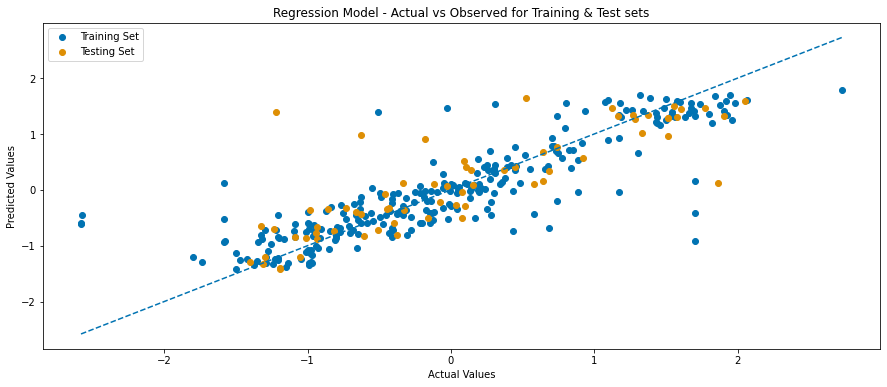

In [13]:
# Plot a scatter plot

actual_vs_predicted_scat(lrm, X_train, y_train, X_test, y_test, 
                         title = 'Regression Model - Actual vs Observed for Training & Test sets')

In [14]:
lrm_dict = model_dict(lrm, X_train, y_train, X_test, y_test, grid_search = False)
lrm_dict

{'Model': 'LinearRegression',
 'Group': 'Baseline',
 'Train_R_Squared': 0.75,
 'Test_R_Squared': 0.69,
 'Train_RMSE': 0.5,
 'Test_RMSE': 0.55}

In [15]:
# This function takes a model and a dictionary of paramters which are to be hypertuned using grid search and cross validation
# The function also calls the model_summary and actual_vs_predicted_scat functions defined earlier
# Note that it's return value is the return value of the model_dict function

def grid_search_model(model, param_grid, x_train, y_train, x_test, y_test, cv = 5, graph = False, title = '', group = 'Baseline'):
    
    grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = cv)
    grid_search.fit(x_train, y_train)
    
    y_preds_train = grid_search.predict(x_train)
    y_preds_test = grid_search.predict(x_test)
    
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best score: {grid_search.best_score_}')
    
    summary = model_summary(grid_search, x_train, y_train, x_test, y_test)
    model_dict_check = model_dict(grid_search, x_train, y_train, x_test, y_test, grid_search = True, group = group)
    
    
    
    if graph == True:
        graph = actual_vs_predicted_scat(grid_search, x_train, y_train, x_test, y_test, 
                                         title = f'{title} Regression Model - Actual vs Observed for Training & Test sets')
        
    return model_dict_check

In [16]:
# Let's use the function for a ridge model

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
              'fit_intercept': [True, False]}

ridge = Ridge()

ridge_model = grid_search_model(ridge, param_grid, X_train, y_train, X_test, y_test, graph = False, title = 'Ridge')

Best parameters: {'alpha': 1, 'fit_intercept': False}
Best score: 0.6438890718395788
R-Squared of the model in training set is: 0.7478653486036957
-----Test set statistics------
R-squared of the model in test set is: 0.6958475380341123
Root mean squared error of the prediction is: 0.5459362543263375
Mean absolute percentage error of the prediction is: 99.15660276839749


In [18]:
# Let's try lasso regression
# I'll use the param_grid defined above

lasso = Lasso()

lasso_model = grid_search_model(lasso, param_grid, X_train, y_train, X_test, y_test, graph = False, title = 'Lasso')

C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.528e-02, tolerance: 2.111e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.214e-02, tolerance: 2.178e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.273e-01, toleranc

Best parameters: {'alpha': 0.001, 'fit_intercept': False}
Best score: 0.6405472173462917
R-Squared of the model in training set is: 0.7477285559704157
-----Test set statistics------
R-squared of the model in test set is: 0.6988498459589085
Root mean squared error of the prediction is: 0.5432350865352411
Mean absolute percentage error of the prediction is: 98.34126220186215


C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.528e-02, tolerance: 2.111e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.214e-02, tolerance: 2.178e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.273e-01, toleranc

In [19]:
# Let's run a decision tree regression


param_grid = {'max_depth': [2, 4, 6, 8, 10],
              'min_samples_split': [2, 4, 6, 8, 10],
              'min_samples_leaf': [1, 2, 4, 6, 8]}


dt_model = grid_search_model(DecisionTreeRegressor(), param_grid, X_train, y_train, X_test, y_test, 
                             graph = False, title = 'Decision Tree')

Best parameters: {'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best score: 0.5601083559519862
R-Squared of the model in training set is: 0.8330030964693053
-----Test set statistics------
R-squared of the model in test set is: 0.56033882819021
Root mean squared error of the prediction is: 0.6563799767151699
Mean absolute percentage error of the prediction is: 123.877786103364


In [20]:
# Let's fit a Random Forest Regressor

ran_for_reg = RandomForestRegressor()

param_grid = {'n_estimators': [10, 50, 100],
              'max_depth': [None, 5, 10]}

ran_for_model = grid_search_model(RandomForestRegressor(), param_grid, X_train, y_train, X_test, y_test, 
                             graph = False, title = 'Random Forest')

Best parameters: {'max_depth': 10, 'n_estimators': 100}
Best score: 0.6346813718565556
R-Squared of the model in training set is: 0.9352541498091508
-----Test set statistics------
R-squared of the model in test set is: 0.6723207596619967
Root mean squared error of the prediction is: 0.5666576179963779
Mean absolute percentage error of the prediction is: 85.06503520683265


In [21]:
# I want to see if including a lag of the dependent variable improves model performance

In [22]:
# I'll create a copy of df_merged_hot_full dataset, I need the full dataset so I can group by geo when creating lag

df_merged_hot_copy = df_merged_hot_full.copy()

In [23]:
# Create lag with shift method, need to drop na's that get introduced, finally I drop the columns I no longer need

df_merged_hot_copy['Yields_lag'] = df_merged_hot_copy.groupby('geo').Yields.shift(periods = 1)

df_merged_hot_copy.dropna(inplace = True)

df_merged_hot_copy.drop(columns = ['crops', 'strucpro', 'geo', 'Year'], inplace = True)

In [24]:
# Create train and test splits again

y = df_merged_hot_copy['Yields']
X = df_merged_hot_copy.drop(columns = 'Yields')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((249, 78), (63, 78), (249,), (63,))

In [25]:
# Let's try linear regression again

lrm = LinearRegression()

lrm.fit(X_train, y_train)

LinearRegression()

In [26]:
# Including the lag significantly improved performance

model_summary(lrm, X_train, y_train, X_test, y_test)

R-Squared of the model in training set is: 0.7308233826596708
-----Test set statistics------
R-squared of the model in test set is: 0.7862862595873201
Root mean squared error of the prediction is: 0.47717840735862005
Mean absolute percentage error of the prediction is: 63.830216662267084


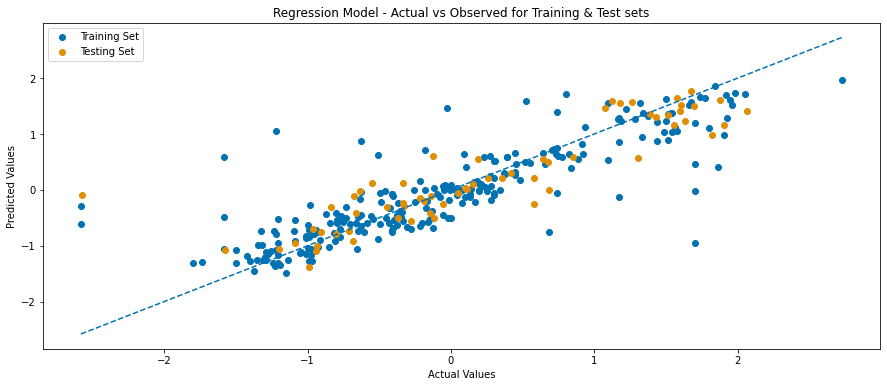

In [27]:
actual_vs_predicted_scat(lrm, X_train, y_train, X_test, y_test, 
                         title = 'Regression Model - Actual vs Observed for Training & Test sets')

In [28]:
# I want to create the dictionary of results, I'll later combine these into a dataframe

lrm_lag = model_dict(lrm, X_train, y_train, X_test, y_test, grid_search = False, group = 'Lag')
lrm_lag

{'Model': 'LinearRegression',
 'Group': 'Lag',
 'Train_R_Squared': 0.73,
 'Test_R_Squared': 0.79,
 'Train_RMSE': 0.52,
 'Test_RMSE': 0.48}

In [29]:
# Re-running ridge regression with the lag

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
              'fit_intercept': [True, False]}

ridge = Ridge()

ridge_model_lag = grid_search_model(ridge, param_grid, X_train, y_train, X_test, y_test, graph = False, title = 'Ridge',
                                   group = 'Lag')

Best parameters: {'alpha': 10, 'fit_intercept': False}
Best score: 0.5737007965632576
R-Squared of the model in training set is: 0.708077085718976
-----Test set statistics------
R-squared of the model in test set is: 0.7828847039723195
Root mean squared error of the prediction is: 0.4809608995502211
Mean absolute percentage error of the prediction is: 68.24321334124895


In [30]:
# Re-running lasso

lasso = Lasso()

lasso_model_lag = grid_search_model(lasso, param_grid, X_train, y_train, X_test, y_test, graph = False, title = 'Lasso',
                                   group = 'Lag')

C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.685e-02, tolerance: 1.812e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.425e-02, tolerance: 1.908e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.402e-01, toleranc

Best parameters: {'alpha': 0.001, 'fit_intercept': True}
Best score: 0.5590295507768828
R-Squared of the model in training set is: 0.7268325825608793
-----Test set statistics------
R-squared of the model in test set is: 0.7991231442555512
Root mean squared error of the prediction is: 0.4626254404507821
Mean absolute percentage error of the prediction is: 61.7408708474298


C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.685e-02, tolerance: 1.812e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.425e-02, tolerance: 1.908e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.402e-01, toleranc

In [31]:
# Re-running decision tree regression

param_grid = {'max_depth': [2, 4, 6, 8, 10],
              'min_samples_split': [2, 4, 6, 8, 10],
              'min_samples_leaf': [1, 2, 4, 6, 8]}


dt_model_lag = grid_search_model(DecisionTreeRegressor(), param_grid, X_train, y_train, X_test, y_test, 
                             graph = False, title = 'Decision Tree', group = 'Lag')

Best parameters: {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best score: 0.45105687075011575
R-Squared of the model in training set is: 0.6037592131786362
-----Test set statistics------
R-squared of the model in test set is: 0.5944853814433737
Root mean squared error of the prediction is: 0.6573063351834286
Mean absolute percentage error of the prediction is: 116.3145915300144


In [32]:
# Re-running random forest

ran_for_reg = RandomForestRegressor()

param_grid = {'n_estimators': [10, 50, 100],
              'max_depth': [None, 5, 10]}

ran_for_model_lag = grid_search_model(RandomForestRegressor(), param_grid, X_train, y_train, X_test, y_test, 
                             graph = False, title = 'Random Forest', group = 'Lag')

Best parameters: {'max_depth': 10, 'n_estimators': 100}
Best score: 0.5314333625432491
R-Squared of the model in training set is: 0.9337285100605163
-----Test set statistics------
R-squared of the model in test set is: 0.7787631932787334
Root mean squared error of the prediction is: 0.4855044907108968
Mean absolute percentage error of the prediction is: 62.165894583077566


In [33]:
# I now try some feature selection

In [38]:
# Below function takes a model and runs feature selection, it then returns a dicionary with two dataframe
# the training df with the chosen features and the test df with the chosen features

def feature_selection(model, x_train, y_train, x_test, step = 1, cv = 5):
    
    selector = RFECV(model, step = step, cv = cv)
    selector = selector.fit(x_train.values, y_train.values)
    
    x_train_selected = x_train.loc[:, selector.support_]
    x_test_selected = x_test.loc[:, selector.support_]
    
    feature_dict = {'x_train': x_train_selected,
                    'x_test': x_test_selected}
    
    return feature_dict

In [39]:
# Let's try feature selection with linear regression

selector_lrm = feature_selection(LinearRegression(), X_train, y_train, X_test)

In [40]:
# I can now train a linear regression with the feature identified in selector_lrm

lrm_feat = LinearRegression()
lrm_feat.fit(selector_lrm['x_train'], y_train)

LinearRegression()

In [41]:
lrm_feat_dict = model_dict(lrm_feat, selector_lrm['x_train'], y_train, selector_lrm['x_test'], 
                           y_test, grid_search = False, group = 'Feature Engineering')

In [42]:
# Let's try with ridge regression

In [43]:
selector_ridge = feature_selection(Ridge(), X_train, y_train, X_test)

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
              'fit_intercept': [True, False]}

ridge_model_feat = grid_search_model(Ridge(), param_grid, selector_ridge['x_train'], y_train, selector_ridge['x_test'], 
                                     y_test, graph = False, title = 'Ridge', group = 'Feature Engineering')

Best parameters: {'alpha': 1, 'fit_intercept': True}
Best score: 0.6186798853447533
R-Squared of the model in training set is: 0.7268005870222012
-----Test set statistics------
R-squared of the model in test set is: 0.7938952445736388
Root mean squared error of the prediction is: 0.4686067788413768
Mean absolute percentage error of the prediction is: 62.455626912900065


In [44]:
# Let's try with lasso regression

In [45]:
selector_lasso = feature_selection(Lasso(), X_train, y_train, X_test)

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
              'fit_intercept': [True, False]}

lasso_model_feat = grid_search_model(Lasso(), param_grid, selector_lasso['x_train'], y_train, selector_lasso['x_test'], 
                                     y_test, graph = False, title = 'Lasso', group = 'Feature Engineering')

Best parameters: {'alpha': 0.001, 'fit_intercept': False}
Best score: 0.5464387202300769
R-Squared of the model in training set is: 0.5764980643398674
-----Test set statistics------
R-squared of the model in test set is: 0.70033913787573
Root mean squared error of the prediction is: 0.5650404940280145
Mean absolute percentage error of the prediction is: 69.55099167756559


In [46]:
# Let's try with decision trees

In [47]:
selector_dt = feature_selection(DecisionTreeRegressor(), X_train, y_train, X_test)

param_grid = {'max_depth': [2, 4, 6, 8, 10],
              'min_samples_split': [2, 4, 6, 8, 10],
              'min_samples_leaf': [1, 2, 4, 6, 8]}

dt_model_feat = grid_search_model(DecisionTreeRegressor(), param_grid, selector_dt['x_train'], y_train, selector_dt['x_test'], 
                                     y_test, graph = False, title = 'Decision Tree', group = 'Feature Engineering')

Best parameters: {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best score: 0.4700719989407983
R-Squared of the model in training set is: 0.728600973937044
-----Test set statistics------
R-squared of the model in test set is: 0.664088379358891
Root mean squared error of the prediction is: 0.5982422411097627
Mean absolute percentage error of the prediction is: 122.92098033730888


In [48]:
# Let's try with random forest regression seen as it performed best before feature selection

In [49]:
selector_ran_for = feature_selection(RandomForestRegressor(), X_train, y_train, X_test)

param_grid = {'n_estimators': [10, 50, 100],
              'max_depth': [None, 5, 10]}

ran_for_model_feat = grid_search_model(RandomForestRegressor(), param_grid, selector_ran_for['x_train'], y_train, 
                                       selector_ran_for['x_test'], y_test, graph = False, title = 'Random Forest', 
                                       group = 'Feature Engineering')

Best parameters: {'max_depth': 10, 'n_estimators': 50}
Best score: 0.5377056234922692
R-Squared of the model in training set is: 0.9337983676979014
-----Test set statistics------
R-squared of the model in test set is: 0.772537460567103
Root mean squared error of the prediction is: 0.49228828652558054
Mean absolute percentage error of the prediction is: 69.17213085922839


In [50]:
# Create a list with all our results dicionaries

model_dict_list = [lrm_dict, ridge_model, lasso_model, dt_model, ran_for_model, lrm_lag, ridge_model_lag, 
lasso_model_lag, dt_model_lag, ran_for_model_lag, lrm_feat_dict, ridge_model_feat, lasso_model_feat,
dt_model_feat, ran_for_model_feat]

In [51]:
# convert to a dataframe and sort by R Squared in the test

model_comp_df = pd.DataFrame(model_dict_list)
model_comp_df.sort_values(by = 'Test_R_Squared', ascending = False, inplace = True)

In [52]:
# Best model is a lasso with a lag included

model_comp_df

,Model,Group,Train_R_Squared,Test_R_Squared,Train_RMSE,Test_RMSE
7,Lasso,Lag,0.73,0.80,0.52,0.46
10,LinearRegression,Feature Engineering,0.71,0.80,0.53,0.47
5,LinearRegression,Lag,0.73,0.79,0.52,0.48
11,Ridge,Feature Engineering,0.73,0.79,0.52,0.47
6,Ridge,Lag,0.71,0.78,0.54,0.48
14,RandomForestRegressor,Feature Engineering,0.86,0.75,0.37,0.52
9,RandomForestRegressor,Lag,0.86,0.74,0.37,0.52
1,Ridge,Baseline,0.75,0.70,0.50,0.55
2,Lasso,Baseline,0.75,0.70,0.50,0.54
4,RandomForestRegressor,Baseline,0.94,0.70,0.25,0.54


In [53]:
# I'll write this out

#model_comp_df.to_csv('model_comp_df.csv')

I'll now do some dimenstionality reduction and clustering

In [54]:
# I want to be able to visualise my data on a graph so I'll use PCE to colapse the dimensions of my explanatory variables to 1

X = df_merged_hot.drop(columns = 'Yields')
X.head()

pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)

In [55]:
# I'll create a new df which has my yields data and the now single dimension explantory variable

df_yields_x_pca = df_merged_hot[['Yields']]
df_yields_x_pca['X_pca'] = X_pca

df_yields_x_pca.head()

C:\Users\justi\AppData\Local\Temp\ipykernel_1820\3660469584.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yields_x_pca['X_pca'] = X_pca


,Yields,X_pca
0,0.309926,-1.154260
1,0.309926,4.758122
2,-0.967975,-2.509003
3,-0.856494,3.669608
4,-0.310445,-0.257922


In [56]:
# Perform KMeans clustering, from experimentation a value of 3 works well

kmeans = KMeans(n_clusters = 3)
clusters = kmeans.fit_predict(df_yields_x_pca)

In [57]:
# Add the clusters and geo information to the dataset

df_yields_x_pca['cluster'] = clusters
df_yields_x_pca['geo'] = df_merged_hot_full.geo

C:\Users\justi\AppData\Local\Temp\ipykernel_1820\2431313066.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yields_x_pca['cluster'] = clusters
C:\Users\justi\AppData\Local\Temp\ipykernel_1820\2431313066.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yields_x_pca['geo'] = df_merged_hot_full.geo


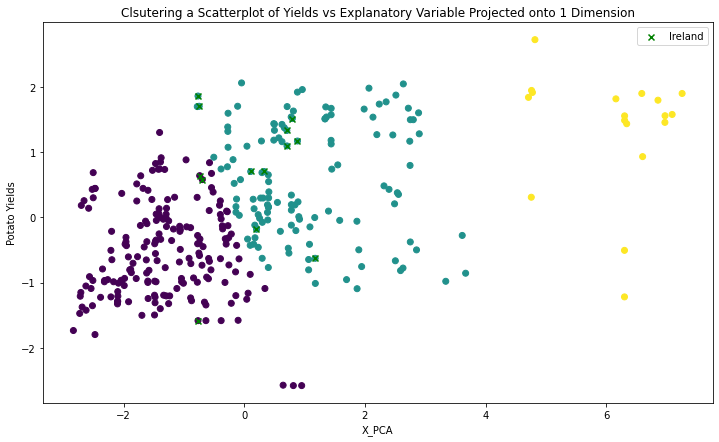

In [58]:
# Produce a scatter plot

# Extract the columns we need from the DataFrame
yields = df_yields_x_pca['Yields']
x_pca = df_yields_x_pca['X_pca']
cluster = df_yields_x_pca['cluster']
geo = df_yields_x_pca['geo']

# Create a figure and axis
fig, ax = plt.subplots(figsize = (12, 7))

# Scatter plot the yield and X_pca values, coloring the points by cluster
ax.scatter(x_pca, yields, c=cluster)

# Highlight the points with geo == 'IE' with an x
ie_mask = geo == 'IE'
ax.scatter(x_pca[ie_mask], yields[ie_mask], marker='x', c='g', label='Ireland')

# Add a legend
ax.legend()
ax.set_xlabel('X_PCA')
ax.set_ylabel('Potato Yields')
ax.set_title('Clsutering a Scatterplot of Yields vs Explanatory Variable Projected onto 1 Dimension')

# Show the plot
plt.show()

#plt.savefig('C:\\Users\\justi\\OneDrive\\Documents\\MSc Data Analytics\\Semester 1 - CA 2\\Plots\\figure25.png')

### Sentiment Analysis

I'll now perform a sentiment analysis on twitter data. I'll also train a logistic regression classifier.

In [59]:
from dotenv import dotenv_values
import requests
import json
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [60]:
# This .env file contains my twitter credentials

config = dotenv_values("C:\\Users\\justi\\OneDrive\\Documents\\MSc Data Analytics\\Semester 1 - CA 2\\.env")

In [ ]:
# Set the search query and the number of tweets to retrieve
query = "potatoes"
count = 100

# Set the API endpoint and the Bearer Token for authenticating the request
endpoint = "https://api.twitter.com/2/tweets/search/recent"
bearer_token = config["BEARER_TOKEN"]

# Set the headers for the request
headers = {
    "Authorization": f"Bearer {bearer_token}",
    "User-Agent": "v2RecentSearchPython",
}

# Set the parameters for the request
params = {
    "query": query,
    "max_results": count,
    "expansions": "author_id,referenced_tweets.id",
    "user.fields": "username",
    "tweet.fields": "public_metrics"
}

# Make the request to the API endpoint
response = requests.get(endpoint, headers=headers, params=params)

tweet_dicts = []

# Check the status code of the response
if response.status_code == 200:
    # If the request was successful, parse the JSON response
    data = response.json()

    # Print the tweets
    for tweet in data["data"]:
        tweet_dict = {
            "id": tweet["id"],
            "like_count": tweet["public_metrics"]["like_count"],
            "quote_count": tweet["public_metrics"]["quote_count"],
            "retweet_count": tweet["public_metrics"]["retweet_count"],
            "text": tweet["text"]
        }
        tweet_dicts.append(tweet_dict)
else:
    # If the request was not successful, print the error message
    print(f"Error: {response.status_code}")

In [ ]:
# Converted tweet_dicts to a dataframe

tweets_df = pd.DataFrame(tweet_dicts)

In [ ]:
# I'll save the dataframe as a csv file so I can reproduce my analysis with the same tweets
#tweets_df.to_csv('tweets_df.csv)

In [61]:
tweets_df = pd.read_csv('tweets_df.csv')

In [62]:
# Before doing the sentiment analysis, I need to process the text to make a clearer signal

In [63]:
# First of all I'll make all words lower case

tweets_df['text'] = tweets_df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
tweets_df['text'].head()

0    today's lunch specials at the catawba deli inc...
1    rt @cobratate: i got beans greens potatoes tom...
2    rt @30vocamusic: becoming potatoes - neru http...
3    now greens, beans, potatoes, and everything el...
4    rt @catturd2: been cooking this all day - my f...
Name: text, dtype: object

In [64]:
# Next I'll remove twitter handles seen as these have nothing to do with the sentiment of the tweet

tweets_df['text'] = tweets_df['text'].str.replace('@\w+', '')
tweets_df.head()

C:\Users\justi\AppData\Local\Temp\ipykernel_1820\2817344102.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets_df['text'] = tweets_df['text'].str.replace('@\w+', '')


,Unnamed: 0,id,like_count,quote_count,retweet_count,text
0,0,1608843281768808448,0,0,0,today's lunch specials at the catawba deli inc...
1,1,1608843248776413185,0,0,3135,rt : i got beans greens potatoes tomatoes lamb...
2,2,1608843235346243589,0,0,29,rt : becoming potatoes - neru https://t.co/3gy...
3,3,1608843229591633920,0,0,0,"now greens, beans, potatoes, and everything el..."
4,4,1608843130538962945,0,0,503,rt : been cooking this all day - my famous cat...


In [65]:
# Next I'll remove punctuation

tweets_df['text'] = tweets_df['text'].str.replace('[^\w\s]', '')
tweets_df['text'].head()

C:\Users\justi\AppData\Local\Temp\ipykernel_1820\2661965721.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets_df['text'] = tweets_df['text'].str.replace('[^\w\s]', '')


0    todays lunch specials at the catawba deli incl...
1    rt  i got beans greens potatoes tomatoes lambs...
2       rt  becoming potatoes  neru httpstco3gyi1s8lt5
3    now greens beans potatoes and everything else ...
4    rt  been cooking this all day  my famous cattl...
Name: text, dtype: object

In [66]:
# Next I'll remove stop words, ie commonly occurring words

stop = stopwords.words('english')

tweets_df['text'] = tweets_df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
tweets_df['text'].head()

0    todays lunch specials catawba deli include 2 c...
1    rt got beans greens potatoes tomatoes lambs ra...
2         rt becoming potatoes neru httpstco3gyi1s8lt5
3    greens beans potatoes everything else saybut s...
4    rt cooking day famous cattle trail stew basica...
Name: text, dtype: object

In [67]:
# I'll next look at frequently occurring words, some of which might not be relevant for sentiment analysis
# I'll remove rt, ie retweet because it's not relevant for sentiment

freq = pd.Series(' '.join(tweets_df['text']).split()).value_counts()[:10]
print(freq)

tweets_df['text'] = tweets_df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq.index[1]))

tweets_df['text'].head()

potatoes    95
rt          43
name        22
like        21
tomatoes    20
sweet       20
day         20
chicken     17
think       13
dogs        12
dtype: int64


0    todays lunch specials catawba deli include 2 c...
1    got beans greens potatoes tomatoes lambs rams ...
2            becoming potatoes neru httpstco3gyi1s8lt5
3    greens beans potatoes everything else saybut s...
4    cooking day famous cattle trail stew basically...
Name: text, dtype: object

In [68]:
# Next I'll consider infrequent words
# I only have a 100 tweets so I won't remove infrequent words just because they're infrequent
# However, I will remove the words which start with https since these will have nothing to do with sentiment

freq = pd.Series(' '.join(tweets_df['text']).split()).value_counts()[-10:]
print(freq)

words_remove = list(freq.index[freq.index.str.startswith('https')])

tweets_df['text'] = tweets_df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in words_remove))

tweets_df['text'].head()

match                 1
perfect               1
say                   1
mind                  1
boggles               1
httpstco7ok9poa3qs    1
httpstcouuafagzcyg    1
httpstcolfbvjgquin    1
love                  1
individually          1
dtype: int64


0    todays lunch specials catawba deli include 2 c...
1    got beans greens potatoes tomatoes lambs rams ...
2            becoming potatoes neru httpstco3gyi1s8lt5
3    greens beans potatoes everything else saybut s...
4    cooking day famous cattle trail stew basically...
Name: text, dtype: object

In [69]:
# Next I'll correct spelling mistakes

tweets_df['text'] = tweets_df['text'].apply(lambda x: str(TextBlob(x).correct()))

tweets_df['text'].head()

0    today lunch special catawba delhi include 2 ch...
1    got beans green potatoes potatoes lambs rams h...
2            becoming potatoes peru httpstco3gyi1s8lt5
3    green beans potatoes everything else salut soo...
4    cooking day famous cattle trail stew basically...
Name: text, dtype: object

In [70]:
# Finally I'll lematize the words

tweets_df['text'] = tweets_df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

tweets_df['text'].head()

0    today lunch special catawba delhi include 2 ch...
1    got bean green potato potato lamb ram hog dog ...
2              becoming potato peru httpstco3gyi1s8lt5
3    green bean potato everything else salut soon m...
4    cooking day famous cattle trail stew basically...
Name: text, dtype: object

In [71]:
# Now I'll produce the sentiment analysis

tweets_df['sentiment'] = tweets_df['text'].apply(lambda x: TextBlob(x).sentiment[0])

tweets_df[['text', 'sentiment']].head()

,text,sentiment
0,today lunch special catawba delhi include 2 ch...,-0.060714
1,got bean green potato potato lamb ram hog dog ...,-0.400000
2,becoming potato peru httpstco3gyi1s8lt5,0.450000
3,green bean potato everything else salut soon m...,-0.256250
4,cooking day famous cattle trail stew basically...,0.500000


In [72]:
# The mean sentiment is fairly neutral

tweets_df['sentiment'].mean()

0.08580643939393935

In [73]:
# Let's try some classification, I'll turn this into a binary classification probelm 

tweets_df['Class'] = tweets_df.sentiment.apply(lambda x: 'Positive' if x >= 0 else 'Negative')
    

In [74]:
tweets_df = tweets_df[['text', 'Class']]
tweets_df.head()

,text,Class
0,today lunch special catawba delhi include 2 ch...,Negative
1,got bean green potato potato lamb ram hog dog ...,Negative
2,becoming potato peru httpstco3gyi1s8lt5,Positive
3,green bean potato everything else salut soon m...,Negative
4,cooking day famous cattle trail stew basically...,Positive


In [75]:
# Create a CountVectorizer object to transform the text strings into numerical features
# Produce train, test splits

y = tweets_df['Class']


vectorizer = CountVectorizer()

X = vectorizer.fit_transform(tweets_df['text'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80, 593), (20, 593), (80,), (20,))

In [76]:
# Create a LogisticRegression model
log_reg = LogisticRegression()

# Fit the model to the training data
log_reg.fit(X_train, y_train)

LogisticRegression()

In [77]:
# Produce predictons for both training and test data

y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

In [78]:
# Create a confusion matrix

conf_mat = confusion_matrix(y_test, y_test_pred)

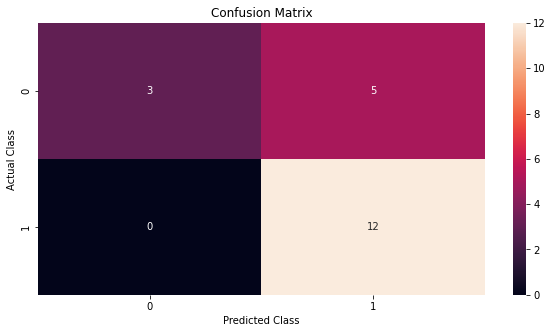

In [79]:
# Produce a plot of confusion matrix

plt.subplots(figsize = (10, 5))

sns.heatmap(conf_mat, annot = True, fmt = 'd')

# Add a title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

# Show the plot
plt.show()

#plt.savefig('C:\\Users\\justi\\OneDrive\\Documents\\MSc Data Analytics\\Semester 1 - CA 2\\Plots\\figure5.png')